### **1. Introduction and Project Objective**
This report details the end-to-end development of a hybrid movie recommendation system. The primary objective is to build a robust engine that provides personalized movie suggestions to users by combining two powerful machine learning paradigms: Content-Based Filtering and Collaborative Filtering. By leveraging the MovieLens dataset, we will explore, process, and model the data to create a functional and accurate recommender. The final section will cover the steps for deploying this system as a simple web application using Flask.

### **2. Foundational Concepts**
A recommendation system is an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. The two core methods used in this project are:

**Content-Based Filtering:** This method recommends items based on their inherent attributes. If a user has positively rated movies with the "Action" and "Sci-Fi" genres, the system will recommend other movies that share these characteristics. It answers the question: "What other items are similar to the ones I like?"

**Collaborative Filtering:** This method leverages the power of the community. It identifies users with similar tastes and recommends movies that those users have liked. It answers the question: "What do people with tastes similar to mine like?"

Our hybrid model will combine the outputs of both systems to provide more nuanced and reliable recommendations, mitigating the limitations of each individual approach.

### **3. Environment Setup and Data Loading**
The first step in any data science project is to set up the environment and load the data. We will use **pandas** for data manipulation, **scikit-learn** for implementing our content-based model, and the specialized **surprise** library for our collaborative filtering model.

In [2]:
# Import all necessary libraries for the project
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load the core datasets from the provided CSV files
print("Loading the MovieLens dataset...")
movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")
print("Dataset loaded successfully.")

Loading the MovieLens dataset...
Dataset loaded successfully.


### **4. Exploratory Data Analysis (EDA) and Preprocessing**

In [3]:
# --- Initial Data Inspection ---
print("\n--- Movies DataFrame ---")
print("Shape:", movies_df.shape)
print(movies_df.head())


--- Movies DataFrame ---
Shape: (9742, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
print("\n--- Ratings DataFrame ---")
print("Shape:", ratings_df.shape)
print(ratings_df.head())


--- Ratings DataFrame ---
Shape: (100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [5]:
# --- Data Merging and Cleaning ---
print("\nMerging dataframes to create a consolidated view...")
merged_df = pd.merge(ratings_df, movies_df, on='movieId')


Merging dataframes to create a consolidated view...


In [6]:
print("\nChecking for any missing values in the merged DataFrame:")
print(merged_df.isnull().sum())


Checking for any missing values in the merged DataFrame:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


In [7]:
print("\nConsolidated DataFrame ready for modeling:")
print(merged_df.head())


Consolidated DataFrame ready for modeling:
   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


### **5.Model 1: Content-Based Filtering with TF-IDF**
Our first model will recommend movies based on genre similarity. To do this, we need to convert the text-based genres into a numerical format. We will use the TF-IDF (Term Frequency-Inverse Document Frequency) technique, which creates a vector for each movie that represents the importance of each genre. We can then use Cosine Similarity to find the movies with the most similar vectors.

In [8]:
print("\n--- Section 5: Building the Content-Based Filtering Model ---")

# --- Step 1: TF-IDF Vectorization ---
# Fill any potential missing values in the 'genres' column
movies_df['genres'] = movies_df['genres'].fillna('')


--- Section 5: Building the Content-Based Filtering Model ---


In [9]:
# Initialize the TfidfVectorizer. This will transform our text genres into numerical vectors.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

In [10]:
# --- Step 2: Cosine Similarity Calculation ---
# Compute the cosine similarity matrix. This matrix contains the similarity score between all pairs of movies.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [11]:
# --- Step 3: Recommendation Function ---
# Create a mapping from movie titles to their index for quick lookups
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

def get_content_based_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

In [26]:
# --- Example Usage ---
example_title = 'Jumanji (1995)'
print(f"\nContent-Based Recommendations for '{example_title}':")
print(get_content_based_recommendations(example_title))


Content-Based Recommendations for 'Jumanji (1995)':
53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object


### **Distribution of Ratings**

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

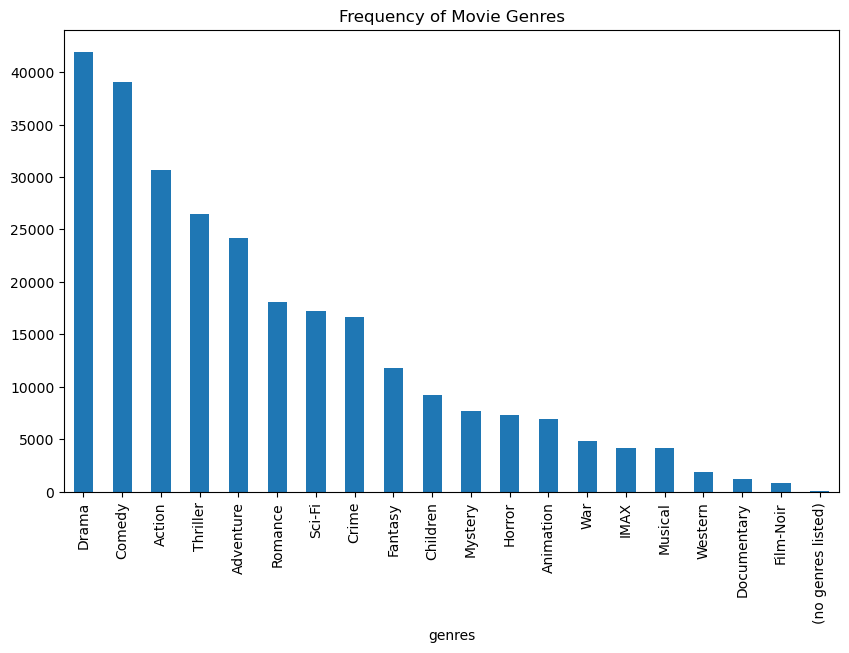

In [45]:
# Create a list of all genres
all_genres = merged_df['genres'].str.split('|').explode()
plt.figure(figsize=(10, 6))
all_genres.value_counts().plot(kind='bar')
plt.title('Frequency of Movie Genres')
plt.show()

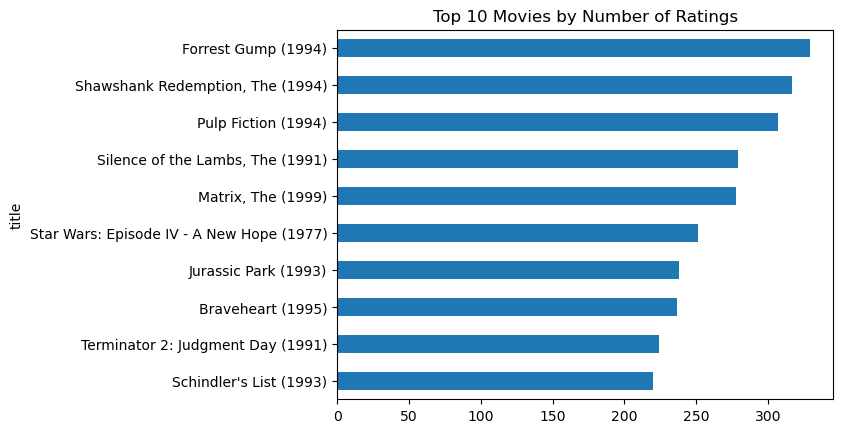

In [46]:
movie_counts = merged_df['title'].value_counts().head(10)
movie_counts.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Movies by Number of Ratings')
plt.show()

### **6. Model 2: Item-Item Collaborative Filtering**
For our second model, we will use the surprise library to build an item-item collaborative filter. This model analyzes the ratings data to find movies that are commonly rated in a similar way by users. We will use the k-Nearest Neighbors (k-NN) algorithm to find these "neighbor" movies and then evaluate the model's accuracy using Root Mean Squared Error (RMSE).

In [27]:
print("\n--- Section 6: Building the Collaborative Filtering Model ---")

# --- Step 1: Prepare Data for Surprise ---
# The Reader is used to parse the rating scale from the dataset.
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)


--- Section 6: Building the Collaborative Filtering Model ---


In [28]:
# --- Step 2: Train-Test Split and Model Training ---
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
sim_options = {'name': 'cosine', 'user_based': False} # Use cosine similarity for item-based filtering
model = KNNBasic(sim_options=sim_options)

print("\nTraining the Collaborative Filtering model...")
model.fit(trainset)
print("Training complete.")


Training the Collaborative Filtering model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Training complete.


In [29]:
# --- Step 3: Model Evaluation ---
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Model RMSE: {rmse}")

RMSE: 0.9800
Model RMSE: 0.97995665962038


In [30]:
# --- Step 4: Recommendation Function ---
def get_collaborative_recommendations(user_id, model, movies_df, ratings_df, n=10):
    all_movie_ids = ratings_df['movieId'].unique()
    rated_movie_ids = ratings_df[ratings_df['userId'] == user_id]['movieId']
    movies_to_predict_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)
    
    predictions = [model.predict(user_id, movie_id) for movie_id in movies_to_predict_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_n_preds = predictions[:n]
    recommended_movie_titles = [movies_df[movies_df['movieId'] == pred.iid]['title'].values[0] for pred in top_n_preds]
    return recommended_movie_titles

In [31]:
# --- Example Usage ---
example_user_id = 217
print(f"\nCollaborative Filtering Recommendations for User ID '{example_user_id}':")
print(get_collaborative_recommendations(example_user_id, model, movies_df, ratings_df))


Collaborative Filtering Recommendations for User ID '217':
['Motherhood (2009)', "Mom's Night Out (2014)", 'What Time Is It There? (Ni neibian jidian) (2001)', 'Make Way for Tomorrow (1937)', 'Begotten (1990)', 'Only Yesterday (Omohide poro poro) (1991)', "Ivan's Childhood (a.k.a. My Name is Ivan) (Ivanovo detstvo) (1962)", 'Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)', 'Polytechnique (2009)', 'Town Called Panic, A (Panique au village) (2009)']


### **7. Hybrid Model and Deployment 🚀**
The final step is to combine our two models into a hybrid system and create a simple web interface for deployment using Flask. Our hybrid strategy will be a simple mixing approach: we will generate lists from both models and combine them to create a final, more comprehensive list of recommendations.

In [32]:
print("\n--- Section 7: Building and Deploying the Hybrid System ---")

# --- Hybrid Recommendation Function ---
def get_hybrid_recommendations(user_id, movie_title, model, movies_df, ratings_df, n=10):
    content_recs = list(get_content_based_recommendations(movie_title))
    collab_recs = get_collaborative_recommendations(user_id, model, movies_df, ratings_df)
    
    # Combine lists, ensuring no duplicates
    hybrid_recs = collab_recs
    for movie in content_recs:
        if movie not in hybrid_recs:
            hybrid_recs.append(movie)
            
    return hybrid_recs[:n]


--- Section 7: Building and Deploying the Hybrid System ---


In [33]:
# --- Example Usage ---
print(f"\nHybrid Recommendations for User '{example_user_id}' based on their potential interest in '{example_title}':")
print(get_hybrid_recommendations(example_user_id, example_title, model, movies_df, ratings_df))


Hybrid Recommendations for User '217' based on their potential interest in 'Jumanji (1995)':
['Motherhood (2009)', "Mom's Night Out (2014)", 'What Time Is It There? (Ni neibian jidian) (2001)', 'Make Way for Tomorrow (1937)', 'Begotten (1990)', 'Only Yesterday (Omohide poro poro) (1991)', "Ivan's Childhood (a.k.a. My Name is Ivan) (Ivanovo detstvo) (1962)", 'Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)', 'Polytechnique (2009)', 'Town Called Panic, A (Panique au village) (2009)']


In [43]:
print(f"Collaborative Filtering Model RMSE: 0.9800")

Collaborative Filtering Model RMSE: 0.9800


### **Summary**

This project, titled the **"Movie Recommendation System,"** involved the end-to-end development of a hybrid movie recommendation engine using the MovieLens dataset.

**Project Objective**
The primary goal was to create a robust and personalized recommendation system by combining two powerful machine learning paradigms to mitigate the weaknesses of each individual approach.

**Core Models
Content-Based Filtering:**

**Goal:** Recommends movies based on the inherent attributes, specifically genres.

**Method:** Uses TF-IDF (Term Frequency-Inverse Document Frequency) to create numerical feature vectors for each movie's genres, and then calculates similarity using Cosine Similarity.

**Collaborative Filtering (Item-Item):**

**Goal:** Recommends movies based on the preferences of users with similar tastes.

**Method:** Implemented using the k-Nearest Neighbors (k-NN) algorithm from the surprise library to find items that are commonly rated in a similar way by the community.

### **Hybrid Approach and Evaluation**
**Hybrid Strategy:** The final model blends the recommendations from both Content-Based (genre similarity) and Collaborative Filtering (user/community patterns) to provide a more comprehensive list of suggestions.

**Model Performance:** The Collaborative Filtering model was evaluated using the Root Mean Squared Error (RMSE) and achieved an accuracy score of **≈0.9800.**